In [1]:
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split

from src.tools import *
from src.MyRadarNetTools import *
from src.MyRadarNet import *

# import random
# SEED = 42
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device is ready: ", device)

Device is ready:  cpu


## Импорт файлов

In [6]:
frames_count = 3
x, y, _ = read_Files(frames_count)

<generator object _walk at 0x7f5fd1c2c0b0>


100%|██████████| 84/84 [00:23<00:00,  3.58it/s]

17485 files loaded.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
train_dataloader, val_dataloader = make_dataloader(X_train, X_test, y_train, y_test, batch=64)

torch.Size([4662, 3, 11, 61]) torch.Size([4662]) torch.Size([1166, 3, 11, 61]) torch.Size([1166])


In [ ]:
model = MyRadarNet(frames_count)
model.cuda()
n_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, eps=1e-08)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

Эпоха: 50;	train loss: 0.596;	valid loss: 0.605;	Точность: 95.85 % 


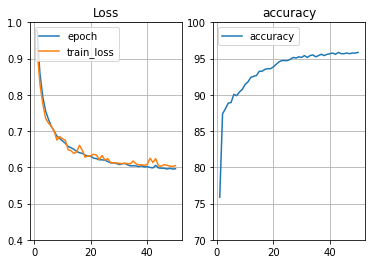

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline

torch.cuda.empty_cache()
train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs)

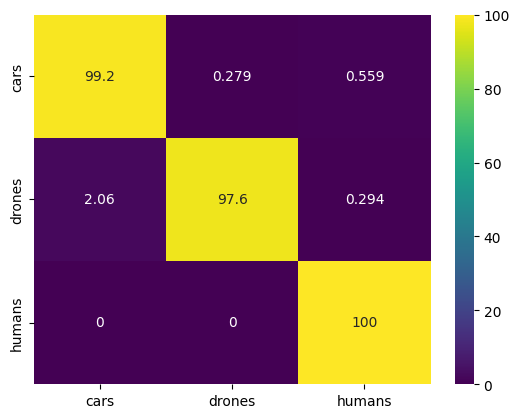

In [8]:
PATH = "model/MyRadarNet_best.pth"
model = torch.load(PATH)
model.eval()
criterion = nn.CrossEntropyLoss()
_, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
plot_conf_matrix(predicted_labels, true_labels)

In [4]:
PATH = "model/MyRadarNet_best.pth"
model = torch.load(PATH)
model.eval()

parr_count = sum(p.numel() for p in model.parameters())
print(parr_count)

33891


## Проверка onnx модели

In [ ]:

from numpy import genfromtxt
import onnxruntime as ort

ort_session = ort.InferenceSession("model/MyRadarNet_best.onnx")
my_data1 = genfromtxt('data/Cars/13-13/001.csv', delimiter=',')
my_data2 = genfromtxt('data/Cars/13-13/002.csv', delimiter=',')
my_data3 = genfromtxt('data/Cars/13-13/003.csv', delimiter=',')
stack_data = np.stack((my_data1, my_data2, my_data3))
stack_data = np.expand_dims(stack_data, axis=0).astype(np.float32)

outputs = ort_session.run(
    None,
    {"modelInput": stack_data},
)
print(outputs[0])